## Traffic sign classification using DCNN



Installing necessary libraries

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam

import matplotlib
matplotlib.use("Agg")

from sklearn.metrics import classification_report

from skimage import transform
from skimage import exposure
from skimage import io

from imutils import paths
import imutils
import matplotlib.pyplot as plt
import numpy as np

import argparse
import random
import os
import glob
import pickle
import time
import cv2

Network architecture

In [2]:
start_time = time.time()

class TrafficSignNet:
  @staticmethod
  def build(width, height, depth, classes):

    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    model.add(Input(shape=inputShape))

    model.add(Conv2D(8, (5, 5), padding="same")) 
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(16, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(16, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.add(Activation("softmax"))
    
    return model

print("[INFO] Model created")

[INFO] Model created


Preparing images

In [3]:


def load_split(basePath, csvPath):

    data = []
    labels = []
    rows = open(csvPath).read().strip().split("\n")[1:]
    random.shuffle(rows)

    for (i, row) in enumerate(rows):
        if i > 0 and i % 1000 == 0:
           print("[INFO] processed {} total images".format(i))

        (label, imagePath) = row.strip().split(",")[-2:]
        imagePath = os.path.sep.join([basePath, imagePath])
        image = io.imread(imagePath)
        image = transform.resize(image, (32, 32))
        image = exposure.equalize_adapthist(image, clip_limit=0.1)
        data.append(image)
        labels.append(int(label))

    data = np.array(data)
    labels = np.array(labels)
    return (data, labels)

print("[INFO] Function defined")

[INFO] Function defined


Data preparation

In [4]:
dataset = "gtsrb/"

labelNames = open("signnames.csv").read().strip().split("\n")[1:]
labelNames = [l.split(",")[0] for l in labelNames]

trainPath = os.path.sep.join([dataset, "Train.csv"])
testPath = os.path.sep.join([dataset, "Test.csv"])

print("[INFO] loading training and testing data...")
(trainX, trainY) = load_split(dataset, trainPath)
(testX, testY) = load_split(dataset, testPath)

trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

numLabels = len(np.unique(trainY))
trainY = to_categorical(trainY, numLabels)
testY = to_categorical(testY, numLabels)

with open('train_test.pickle', 'wb') as f:
    pickle.dump([trainX, trainY, testX, testY], f)

print("[INFO] saving training and testing data...")

[INFO] loading training and testing data...
[INFO] processed 1000 total images
[INFO] processed 2000 total images
[INFO] processed 3000 total images
[INFO] processed 4000 total images
[INFO] processed 5000 total images
[INFO] processed 6000 total images
[INFO] processed 7000 total images
[INFO] processed 8000 total images
[INFO] processed 9000 total images
[INFO] processed 10000 total images
[INFO] processed 11000 total images
[INFO] processed 12000 total images
[INFO] processed 13000 total images
[INFO] processed 14000 total images
[INFO] processed 15000 total images
[INFO] processed 16000 total images
[INFO] processed 17000 total images
[INFO] processed 18000 total images
[INFO] processed 19000 total images
[INFO] processed 20000 total images
[INFO] processed 21000 total images
[INFO] processed 22000 total images
[INFO] processed 23000 total images
[INFO] processed 24000 total images
[INFO] processed 25000 total images
[INFO] processed 26000 total images
[INFO] processed 27000 total 

Data Augmentation and model preparing

In [5]:
numLabels = trainY.shape[1]

NUM_EPOCHS = 15
INIT_LR = 1e-3
BS = 64
with open('train_test.pickle', 'rb') as f:
    trainX, trainY, testX, testY = pickle.load(f)

aug = ImageDataGenerator(
  rotation_range=10,
  zoom_range=0.15,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.15,
  horizontal_flip=False,
  vertical_flip=False,
  fill_mode="nearest")

print("[INFO] compiling model...")

lr_schedule = ExponentialDecay(
    initial_learning_rate=INIT_LR,
    decay_steps=10000,
    decay_rate=INIT_LR / (NUM_EPOCHS * 0.5))
opt = Adam(learning_rate=lr_schedule)

model = TrafficSignNet.build(width=32, height=32, depth=3,
  classes=numLabels)
model.compile(loss="categorical_crossentropy", optimizer=opt,
  metrics=["accuracy"])

classTotals = trainY.sum(axis=0)
classWeight = classTotals.max() / classTotals
classWeightD = {x: classWeight[x] for x in range(0,classWeight.shape[0]) }

print("[INFO] model ready to learn...")

[INFO] compiling model...
[INFO] model ready to learn...


Learning phase

In [6]:
print("[INFO] training network...")
H = model.fit(
  aug.flow(trainX, trainY, batch_size=BS),
  validation_data=(testX, testY),
  epochs=NUM_EPOCHS,
  class_weight=classWeightD,
  verbose=1)

print("[INFO] serializing network to '{}'... trafficsignnet.keras")
model.save("trafficsignnet.keras")


print("[INFO] training network done")

[INFO] training network...
Epoch 1/15


c:\Users\ignac\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


613/613 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - accuracy: 0.0827 - loss: 9.6179 - val_accuracy: 0.0977 - val_loss: 3.7222
Epoch 2/15
613/613 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - accuracy: 0.3224 - loss: 5.3437 - val_accuracy: 0.0770 - val_loss: 3.9760
Epoch 3/15
613/613 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.4268 - loss: 4.1866 - val_accuracy: 0.6268 - val_loss: 1.1756
Epoch 4/15
613/613 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - accuracy: 0.4890 - loss: 3.5681 - val_accuracy: 0.5933 - val_loss: 1.2358
Epoch 5/15
613/613 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - accuracy: 0.5194 - loss: 3.2528 - val_accuracy: 0.6818 - val_loss: 0.9785
Epoch 6/15
613/613 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - accuracy: 0.5461 - loss: 3.0833 - val_accuracy: 0.6912 - val_loss: 0.9595
Epoch 7/15
613/613 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - accuracy: 0.5620 - loss: 3.0081 - val_accuracy: 0.7099 - val_loss: 0.9098
Epoch 8/15
613/613 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.5663 - loss: 2.9104 - val_accurac

Evaluation

[INFO] evaluating network...
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
                               precision    recall  f1-score   support

         Speed limit (20km/h)       0.12      0.68      0.21        60
         Speed limit (30km/h)       0.49      0.57      0.53       720
         Speed limit (50km/h)       0.58      0.33      0.42       750
         Speed limit (60km/h)       0.43      0.53      0.47       450
         Speed limit (70km/h)       0.76      0.60      0.67       660
         Speed limit (80km/h)       0.55      0.37      0.45       630
  End of speed limit (80km/h)       0.84      0.85      0.84       150
        Speed limit (100km/h)       0.48      0.68      0.56       450
        Speed limit (120km/h)       0.46      0.37      0.41       450
                   No passing       0.96      0.65      0.78       480
 No passing veh over 3.5 tons       0.83      0.94      0.88       660
 Right-of-way at intersection       0.82      0.90      0.86       420
      

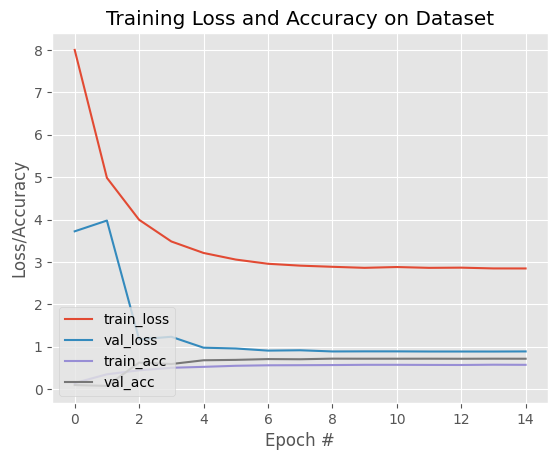

In [7]:
%matplotlib inline

print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1),
  predictions.argmax(axis=1), target_names=labelNames))

N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("train.png")



inference

In [8]:
print("[INFO] loading model...")
model = load_model("trafficsignnet.keras")
labelNames = open("signnames.csv").read().strip().split("\n")[1:]
labelNames = [l.split(",")[0] for l in labelNames]
print("[INFO] predicting...")
imagePaths = list(paths.list_images("gtsrb/Test"))
random.shuffle(imagePaths)
imagePaths = imagePaths[:25]

if not os.path.exists('examples'):
  os.mkdir('examples')

for (i, imagePath) in enumerate(imagePaths):

  image = io.imread(imagePath)
  image = transform.resize(image, (32, 32))
  image = exposure.equalize_adapthist(image, clip_limit=0.1)
  image = image.astype("float32") / 255.0
  image = np.expand_dims(image, axis=0)

  preds = model.predict(image)
  j = preds.argmax(axis=1)[0]
  label = labelNames[j]

  image = cv2.imread(imagePath)
  image = imutils.resize(image, width=128)
  cv2.putText(image, label, (5, 15), cv2.FONT_HERSHEY_SIMPLEX,
    0.45, (0, 0, 255), 2)
  p = os.path.sep.join(["examples", "{}.png".format(i)])
  cv2.imwrite(p, image)

print("[INFO] done...")

print("--- %s seconds ---" % (time.time() - start_time))

[INFO] loading model...
[INFO] predicting...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[INF

Accuracy visualisation


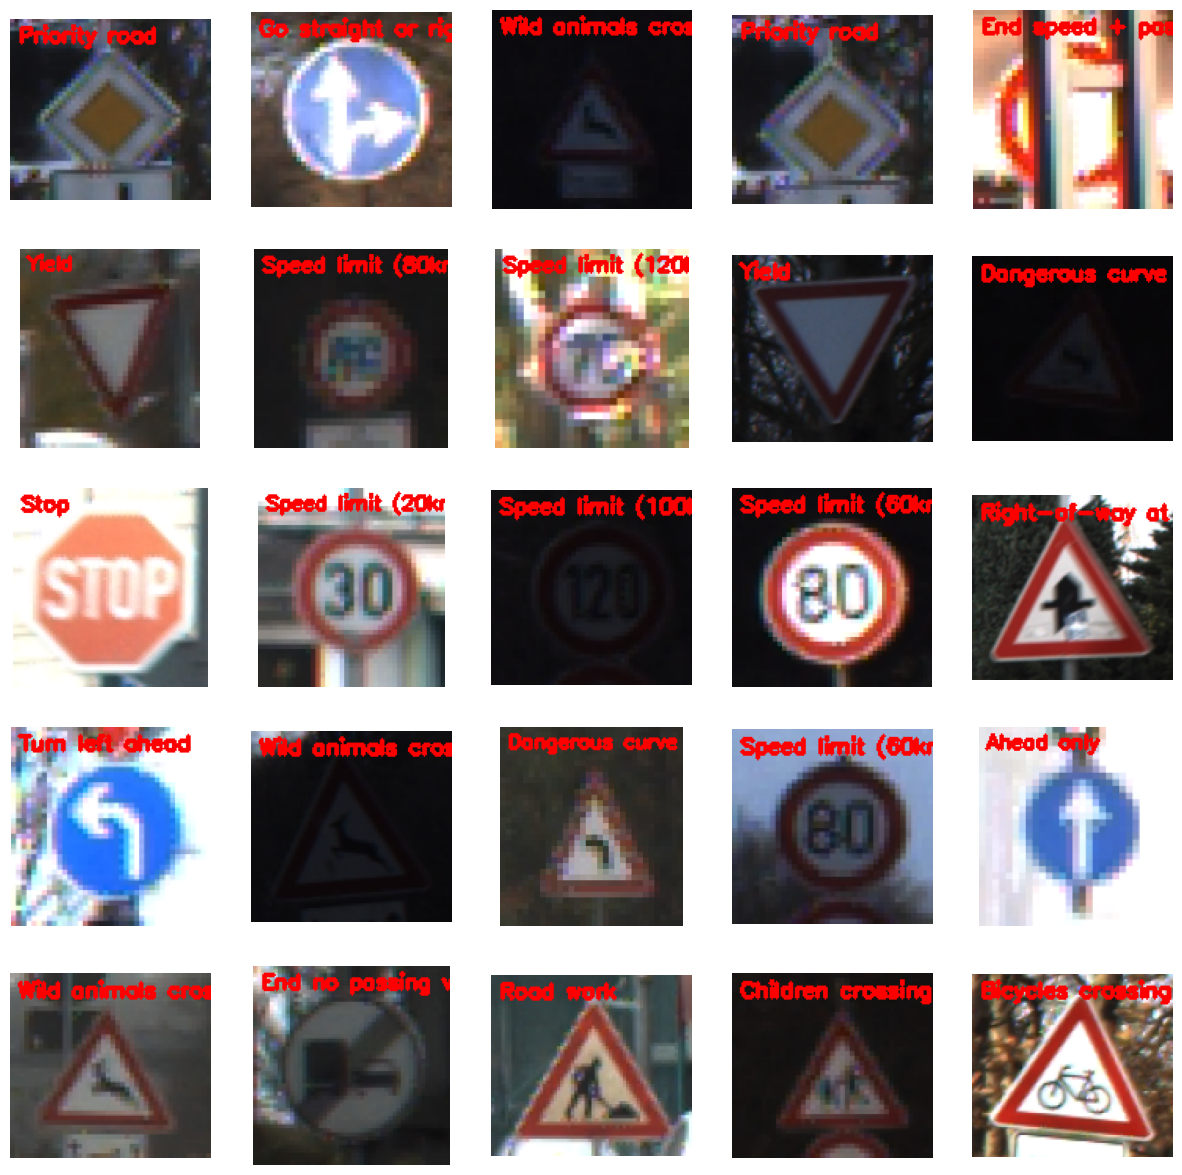

In [9]:
path="examples/*.png"
images = []
for image in glob.glob(path):
    img = cv2.imread( image, cv2.IMREAD_COLOR)
    img = cv2.cvtColor( img, cv2.COLOR_BGR2RGB)
    images.append( img )

fig=plt.figure(figsize=(15,15))
for i in range(len(images)):
    plt.subplot(5,5,i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()